# **Load Packages**

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import keras 
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization 
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib.inline
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix

UsageError: Line magic function `%matplotlib.inline` not found.


# **Loading the Data**

Loading the excel file

In [5]:
train_data = pd.read_excel('../input/dry-bean-dataset-uci/Dry_Bean_Dataset.xlsx')
train_data.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


# **Exploring the Data**

Calculate and plot the correlation matrix  between features

In [6]:
x = train_data.iloc[:,:-1]

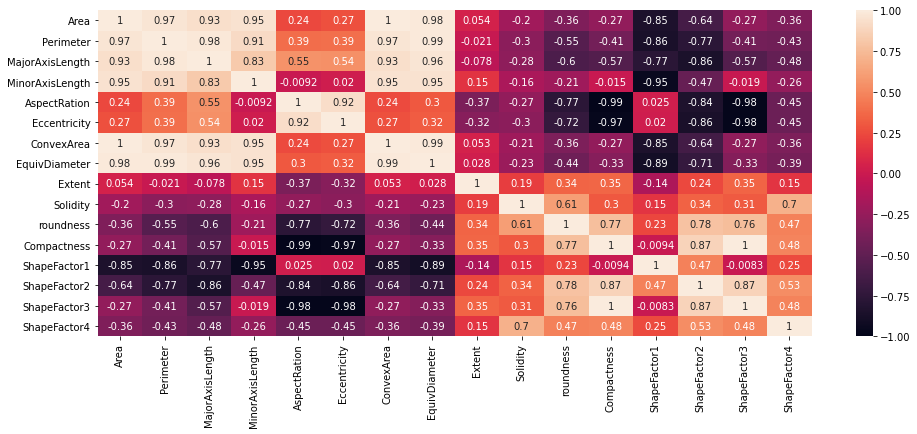

In [7]:
x.corr
plt.figure(figsize=(16, 6))
sns_plot = sns.heatmap(x.corr(), vmin=-1, vmax=1, annot=True)

plt.show()
figure = sns_plot.get_figure()    
figure.savefig('corr.png', dpi=400)

From the above correlation matrix there are some relation which are too correalte to each other. So we drop that features which have correlation coefficient greater than 0.95.

In [8]:
data = train_data.drop(columns=['Area','Perimeter', 'ConvexArea', 'EquivDiameter', 'Compactness'])

In [9]:
data

,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,Extent,Solidity,roundness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,208.178117,173.888747,1.197191,0.549812,0.763923,0.988856,0.958027,0.007332,0.003147,0.834222,0.998724,SEKER
1,200.524796,182.734419,1.097356,0.411785,0.783968,0.984986,0.887034,0.006979,0.003564,0.909851,0.998430,SEKER
2,212.826130,175.931143,1.209713,0.562727,0.778113,0.989559,0.947849,0.007244,0.003048,0.825871,0.999066,SEKER
3,210.557999,182.516516,1.153638,0.498616,0.782681,0.976696,0.903936,0.007017,0.003215,0.861794,0.994199,SEKER
4,201.847882,190.279279,1.060798,0.333680,0.773098,0.990893,0.984877,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...
13606,288.721612,185.944705,1.552728,0.765002,0.714574,0.990331,0.916603,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,281.576392,190.713136,1.476439,0.735702,0.799943,0.990752,0.922015,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,281.539928,191.187979,1.472582,0.734065,0.729932,0.989899,0.918424,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,283.382636,190.275731,1.489326,0.741055,0.705389,0.987813,0.907906,0.006724,0.001852,0.668237,0.995222,DERMASON


In [10]:
#Randomly shuffle the all data
from sklearn.utils import shuffle
data = shuffle(data, random_state=10) 

In [11]:
def code_categorical(df):
    """
    Marking class names to labels

    """
    for i in range(len(df)):                               
        if df.iloc[i,-1]=="SEKER":
            df.iloc[i,-1]=0
        elif df.iloc[i,-1]=='BARBUNYA':
            df.iloc[i,-1]=1
        elif df.iloc[i,-1]=='BOMBAY':
            df.iloc[i,-1]=2
        elif df.iloc[i,-1]=='CALI':
            df.iloc[i,-1]=3
        elif df.iloc[i,-1]== 'HOROZ':
            df.iloc[i,-1]=4
        elif df.iloc[i,-1]=='SIRA':
            df.iloc[i,-1]=5
        else:
            df.iloc[i,-1]=6
    return df                   

In [12]:
#Labeling the class names
data = code_categorical(data)

In [13]:
data.head()

,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,Extent,Solidity,roundness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
9122,291.035510,202.736418,1.435536,0.717456,0.720260,0.990243,0.925733,0.006288,0.001877,0.695698,0.998700,5
10906,239.290365,151.507721,1.579394,0.774026,0.799887,0.988280,0.899113,0.008446,0.002068,0.629995,0.995010,6
6434,375.500237,182.420075,2.058437,0.874067,0.605604,0.987603,0.793945,0.007014,0.001011,0.483405,0.995059,4
13090,271.011395,177.078859,1.530456,0.757013,0.764418,0.989274,0.915004,0.007202,0.001890,0.652333,0.998367,6
9967,336.765474,202.457312,1.663390,0.799112,0.789525,0.985418,0.864695,0.006332,0.001393,0.597085,0.993185,5


In [14]:
#Split the data into train and test set of test_size = 0.2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1],data.iloc[:,-1],test_size=0.2)
print("\nX_train:\n")
print(X_train.head())
print(X_train.shape)

print("\nX_test:\n")
print(X_test.head())
print(X_test.shape)


X_train:

       MajorAxisLength  MinorAxisLength  AspectRation  Eccentricity    Extent  \
6766        372.871747       193.926138      1.922751      0.854113  0.729318   
3858        676.709830       428.762150      1.578287      0.773662  0.786109   
9136        314.928214       188.437888      1.671257      0.801233  0.794495   
12739       269.707828       169.753040      1.588825      0.777085  0.785324   
12418       264.452899       165.460646      1.598283      0.780087  0.789722   

       Solidity  roundness  ShapeFactor1  ShapeFactor2  ShapeFactor3  \
6766   0.987509   0.816411      0.006587      0.001092      0.518386   
3858   0.986188   0.871726      0.003003      0.000727      0.626518   
9136   0.987790   0.868905      0.006794      0.001484      0.595078   
12739  0.987019   0.902212      0.007563      0.001818      0.624172   
12418  0.990720   0.897174      0.007717      0.001853      0.623918   

       ShapeFactor4  
6766       0.996728  
3858       0.988826  
913

In [15]:
#Converting the data to numpy array and reshape to feed into the model
X = X_train.to_numpy(dtype=np.float32)
y = y_train.to_numpy(dtype=np.float32).reshape(-1,1)

In [16]:
X_test = X_test.to_numpy(dtype=np.float32)
y_test = y_test.to_numpy(dtype=np.float32).reshape(-1,1)

# **Using RandomForestClassifier**



In [17]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
RFC=RandomForestClassifier(n_estimators=100, random_state=50,
        max_features="auto")

#Train the model using the training sets
RFC.fit(X, y)

y_pred=RFC.predict(X_test)
print(RFC.predict(X_test))

[6. 4. 4. ... 5. 0. 3.]


In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9250826294528094

In [19]:
from sklearn.metrics import confusion_matrix
RFC_matrix = confusion_matrix(y_test, y_pred)

<Figure size 800x960 with 0 Axes>

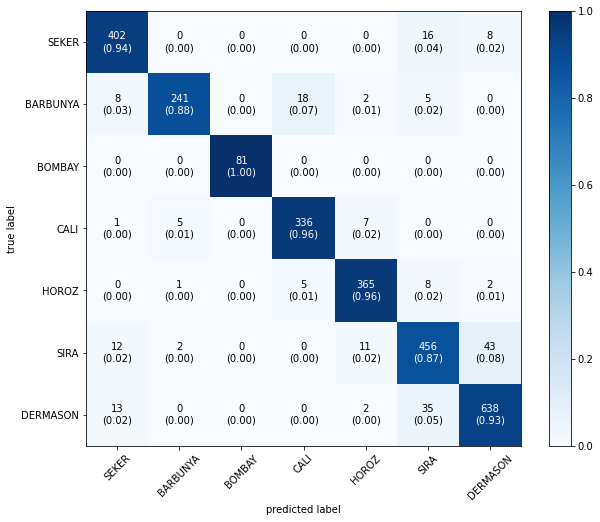

In [20]:
from matplotlib.pyplot import figure
class_names= ['SEKER','BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON']
figure(figsize=(10, 12), dpi=80)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=RFC_matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,figsize=(10, 8),
                                class_names = class_names)
plt.show()

# **Using DecisionTreeClassifier**

In [21]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(min_samples_split=20,criterion="gini", max_depth=5,min_samples_leaf=10)

DTC.fit(X,y)
y_pred=DTC.predict(X_test)

In [22]:
accuracy_score(y_test, y_pred)

0.8854204921042967

In [23]:
DTC_matrix = confusion_matrix(y_test, y_pred)

<Figure size 800x960 with 0 Axes>

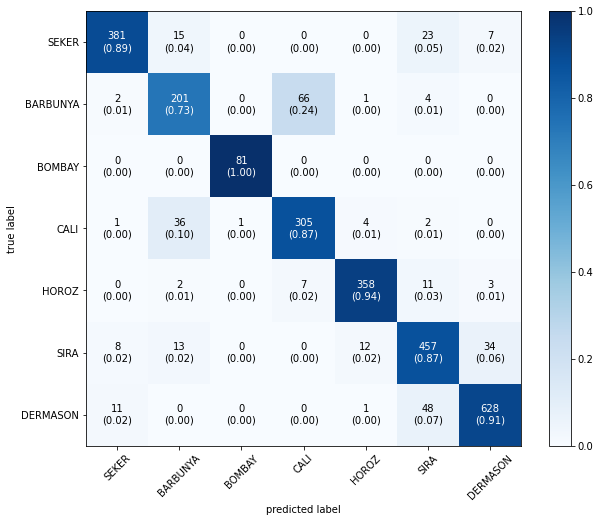

In [24]:
figure(figsize=(10, 12), dpi=80)

fig, ax = plot_confusion_matrix(conf_mat=DTC_matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,figsize=(10, 8),
                                class_names = class_names)
plt.show()

# **Using XGBClassifier**

In [48]:
#!pip install xgboost
from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

XGB = XGBClassifier(n_estimators=100,eta=0.05, subsample=0.5, colsample_bytree=0.95)
XGB.fit(X, y, eval_set = [(X, y), (X_test,y_test)])
# make predictions for test data
XGB_pred = XGB.predict(X_test)
XGB_predictions = [round(value) for value in XGB_pred]
# evaluate predictions
XGB_accuracy = accuracy_score(y_test, XGB_predictions)


[19:02:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.79978	validation_1-mlogloss:1.80254
[1]	validation_0-mlogloss:1.67474	validation_1-mlogloss:1.68045
[2]	validation_0-mlogloss:1.56634	validation_1-mlogloss:1.57446
[3]	validation_0-mlogloss:1.47041	validation_1-mlogloss:1.48083
[4]	validation_0-mlogloss:1.38461	validation_1-mlogloss:1.39743
[5]	validation_0-mlogloss:1.30727	validation_1-mlogloss:1.32235
[6]	validation_0-mlogloss:1.23657	validation_1-mlogloss:1.25324
[7]	validation_0-mlogloss:1.17182	validation_1-mlogloss:1.19042
[8]	validation_0-mlogloss:1.11286	validation_1-mlogloss:1.13296
[9]	validation_0-mlogloss:1.05886	validation_1-mlogloss:1.08067
[10]	validation_0-mlogloss:1.00844	validation_1-mlogloss:1.03156
[11]	validation_0-mlogloss:0.96125	validat

In [49]:
print("Accuracy: %.3f%%" % (XGB_accuracy * 100.0))

Accuracy: 92.949%


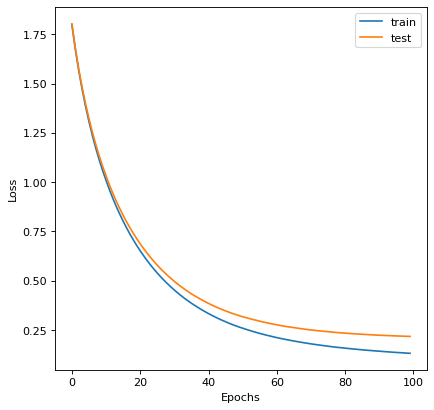

In [50]:
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

results = XGB.evals_result()
figure(figsize=(6, 6), dpi=80)
# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# show the legend
plt.legend()
# show the plot
plt.show()

In [51]:
#Confusion matrix
XGB_matrix = confusion_matrix(y_test, XGB_predictions)

<Figure size 800x960 with 0 Axes>

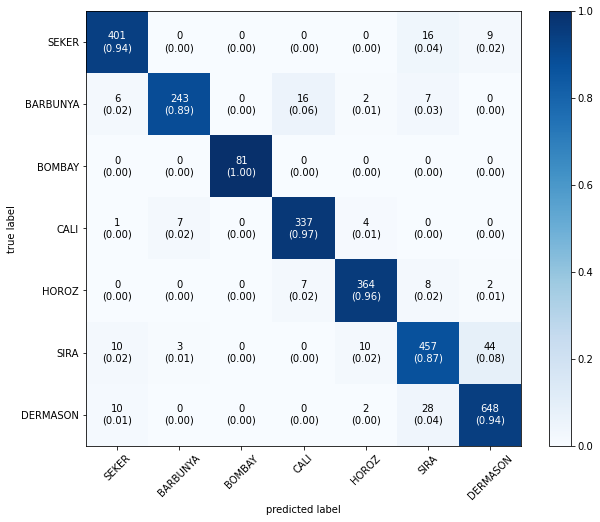

In [52]:
figure(figsize=(10, 12), dpi=80)

fig, ax = plot_confusion_matrix(conf_mat=XGB_matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,figsize=(10, 8),
                                class_names=class_names)
plt.show()

# **Using SVM**

In [53]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
SVM = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
SVM.fit(X, y)

#Predict the response for test dataset
SVM_pred = SVM.predict(X_test)

SVM_accuracy = accuracy_score(y_test, SVM_pred)
print("Accuracy: %.3f%%" % (SVM_accuracy * 100.0))

Accuracy: 90.305%


In [54]:
#Confusion matrix
SVM_matrix = confusion_matrix(y_test, SVM_pred)

<Figure size 800x960 with 0 Axes>

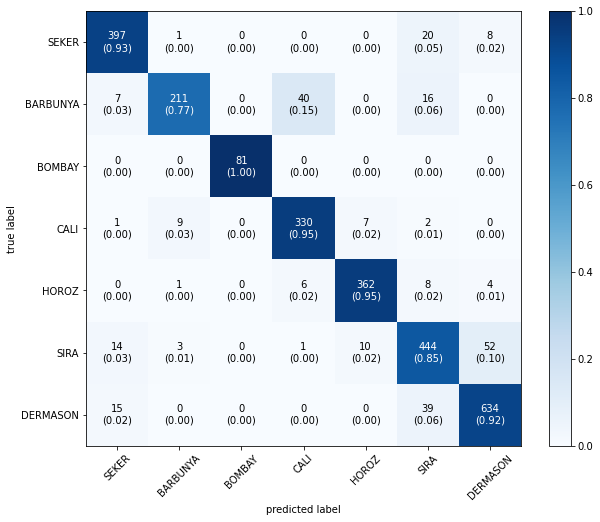

In [55]:
figure(figsize=(10, 12), dpi=80)

fig, ax = plot_confusion_matrix(conf_mat=SVM_matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,figsize=(10, 8),
                                class_names = class_names)
plt.show()

# **Using MLP**

In [62]:
def build_model():
    
    """
    This model contain five Fully Connected (FC) layers with combination of Dropout layer.
    A final FC layer is added with seven units and a softmax activation for multiclass classification.
    
    """
    model = Sequential()
        
    model.add(Dense(128, activation = 'relu', input_shape=(11,)))
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
       
    model.add(Dense(7, activation = 'softmax'))
        
    return model

In [63]:
MLP = build_model()
#Compile the Model
MLP.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
MLP.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1536      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)               

In [64]:
#Train the Model
MLP.fit(x=X, y=y, batch_size=32, epochs=100,
    validation_split=0.2,  shuffle=True )

Epoch 1/100
273/273 [==============================] - 2s 4ms/step - loss: 0.9860 - accuracy: 0.6660 - val_loss: 0.8526 - val_accuracy: 0.6364
Epoch 2/100
273/273 [==============================] - 1s 3ms/step - loss: 0.5062 - accuracy: 0.8170 - val_loss: 0.4894 - val_accuracy: 0.8081
Epoch 3/100
273/273 [==============================] - 1s 3ms/step - loss: 0.4973 - accuracy: 0.8170 - val_loss: 0.3472 - val_accuracy: 0.8719
Epoch 4/100
273/273 [==============================] - 1s 3ms/step - loss: 0.4735 - accuracy: 0.8304 - val_loss: 0.3340 - val_accuracy: 0.8788
Epoch 5/100
273/273 [==============================] - 1s 3ms/step - loss: 0.4486 - accuracy: 0.8323 - val_loss: 0.4411 - val_accuracy: 0.8150
Epoch 6/100
273/273 [==============================] - 1s 3ms/step - loss: 0.4424 - accuracy: 0.8400 - val_loss: 0.3837 - val_accuracy: 0.8444
Epoch 7/100
273/273 [==============================] - 1s 3ms/step - loss: 0.4457 - accuracy: 0.8389 - val_loss: 0.3175 - val_accuracy: 0.8811

Epoch 58/100
273/273 [==============================] - 1s 4ms/step - loss: 0.3747 - accuracy: 0.8601 - val_loss: 0.5838 - val_accuracy: 0.7709
Epoch 59/100
273/273 [==============================] - 1s 4ms/step - loss: 0.3702 - accuracy: 0.8645 - val_loss: 0.3605 - val_accuracy: 0.8641
Epoch 60/100
273/273 [==============================] - 1s 4ms/step - loss: 0.3917 - accuracy: 0.8589 - val_loss: 0.2870 - val_accuracy: 0.8866
Epoch 61/100
273/273 [==============================] - 1s 4ms/step - loss: 0.3672 - accuracy: 0.8601 - val_loss: 0.5759 - val_accuracy: 0.7672
Epoch 62/100
273/273 [==============================] - 1s 3ms/step - loss: 0.3627 - accuracy: 0.8635 - val_loss: 1.0371 - val_accuracy: 0.6703
Epoch 63/100
273/273 [==============================] - 1s 3ms/step - loss: 0.3526 - accuracy: 0.8685 - val_loss: 0.3104 - val_accuracy: 0.8843
Epoch 64/100
273/273 [==============================] - 1s 4ms/step - loss: 0.3666 - accuracy: 0.8665 - val_loss: 0.3625 - val_accuracy:

In [65]:
MLP_results = MLP.evaluate(X_test, y_test)
MLP_pred = MLP.predict(X_test)

print("Loss of the model: ", MLP_results[0])
print("Accuracy of the model is: ",  MLP_results[1]*100)

86/86 [==============================] - 0s 1ms/step - loss: 1.2378 - accuracy: 0.6900
Loss of the model:  1.2378472089767456
Accuracy of the model is:  69.00477409362793
